## Credit Risk Classification

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## EDA

In [2]:
#read/open the dataset
path = r'..\data'

#the first column is the index
df = pd.read_csv(path + '\german_credit_data.csv', index_col='Unnamed: 0')

In [4]:
#overview of the dataset
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


In [5]:
#There are 1000 rows and 10 features in the dataset
df.shape

(1000, 10)

There is an interesting observation we can make by looking at the below information. There are
twice as many men than women who have applied and received credit.

In [6]:
#distribution between men and women
print('Distibution based on gender:\n' + str(df['Sex'].value_counts()), '\n')
print(df.groupby('Sex')['Age'].mean())

Distibution based on gender:
male      690
female    310
Name: Sex, dtype: int64 

Sex
female    32.803226
male      36.778261
Name: Age, dtype: float64


In [7]:
#preparing the data for the barplot
list1 = [i for i in df.groupby('Sex')['Credit amount'].mean()]
labels = ['Women', 'Men']
colors = ['gray', 'b']

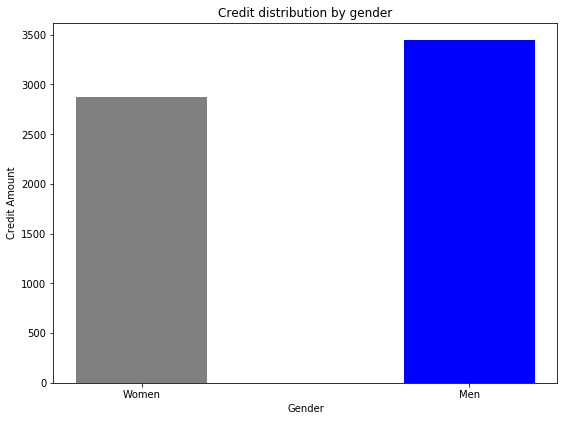

In [8]:
#barplot showing the average credit amount that each gender receives
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0, 1, 1, 1])
ax.bar(labels, list1, color=colors, width=0.4)
ax.set_ylabel('Credit Amount (in DM)
              ')
ax.set_xlabel('Gender')
ax.set_title('Credit distribution by gender')
plt.show()

It is evident from the above barplot that men get an approximately **19%** higher credit amount than women.

In [9]:
#preparing the data for the barplot
purpose = np.unique(df['Purpose'])
no_purpose = df['Purpose'].value_counts()
colors_1 = ['brown','g','r', 'gold', 'm', 'k', 'tab:blue', 'gray']

Most customers, around **34%**, receive credit for business purposes. Car loans are quite popular, as well as credit for house appliances. On the other hand, credit for holidays and repairs are rarely been given.

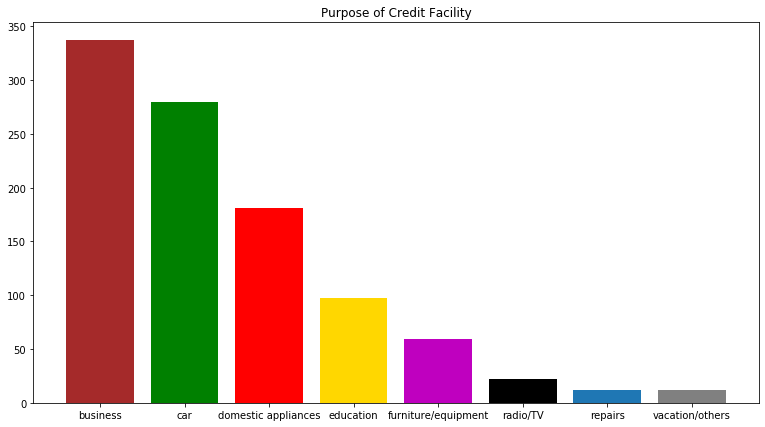

In [10]:
#Plot showing the reason for credit
plt.figure(figsize=(13,7))
plt.bar(purpose, no_purpose, color=colors_1)
plt.title('Purpose of Credit Facility')
plt.show()

Let's have a look at the distribution of ages in the dataset. We are going to use a boxplot for this.

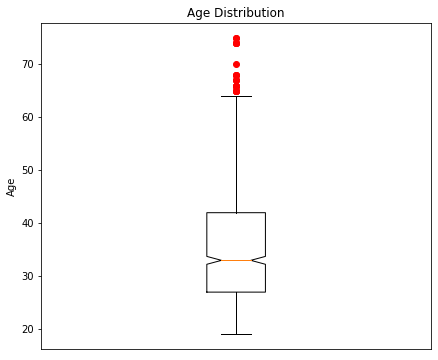

In [11]:
#boxplot
plt.figure(figsize=(7,6))
plt.boxplot(df['Age'], notch=True, sym='r')
plt.title('Age Distribution')
plt.xticks([])
plt.ylabel('Age')
plt.show()

The median age is around the age of 33 and most customers who received credit are between ages 27 - 41. It is also evident that there are some outliers (Ages > 63). <br>
We also want to check whether our dataset is balanced or not. 

In [12]:
print(f"Risk profile of customers:\n\n{df['Risk'].value_counts()}")

Risk profile of customers:

good    700
bad     300
Name: Risk, dtype: int64


It turns out that in this case we are dealing with an imbalanced dataset. We need to consider if we need to deploy an under/oversampling technique.

In [28]:
df.groupby('Risk')['Job'].value_counts()

Risk  Job
bad   2      186
      1       56
      3       51
      0        7
good  2      444
      1      144
      3       97
      0       15
Name: Job, dtype: int64